<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Classical-Baseball-Statistics" data-toc-modified-id="Classical-Baseball-Statistics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Classical Baseball Statistics</a></span><ul class="toc-item"><li><span><a href="#Computing-Classical-Statistics" data-toc-modified-id="Computing-Classical-Statistics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Computing Classical Statistics</a></span></li><li><span><a href="#Classical-Stats-and-Runs-Scored" data-toc-modified-id="Classical-Stats-and-Runs-Scored-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Classical Stats and Runs Scored</a></span><ul class="toc-item"><li><span><a href="#Correlation-with-Team-Runs" data-toc-modified-id="Correlation-with-Team-Runs-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Correlation with Team Runs</a></span></li></ul></li><li><span><a href="#Correlation-Between-Statistics" data-toc-modified-id="Correlation-Between-Statistics-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Correlation Between Statistics</a></span></li><li><span><a href="#On-Your-Own:-Correlation-with-Team-Runs" data-toc-modified-id="On-Your-Own:-Correlation-with-Team-Runs-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>On Your Own: Correlation with Team Runs</a></span><ul class="toc-item"><li><span><a href="#Computing-Team-wOBA-and-OPS" data-toc-modified-id="Computing-Team-wOBA-and-OPS-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Computing Team wOBA and OPS</a></span></li><li><span><a href="#Linear-fits-and-correlations-for-OPS-and-wOBA" data-toc-modified-id="Linear-fits-and-correlations-for-OPS-and-wOBA-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Linear fits and correlations for OPS and wOBA</a></span></li></ul></li></ul></li></ul></div>

# Demo - Offensive Metrics in Baseball


The classical baseball statistics are _Batting Average_, _On-Base Percentage_, and _Slugging Percentage_, which make up what is commonly known as a batters _Slash Line_ due to how the stats are displayed in order with a "/" between them.  

This demo will explore how these metrics perform in quantifying team run scoring performance.  We will look at how well a statistic correlates with team run scoring to determine how well it serves as a measurement of a team's ability to score runs.  We will then look at advanced metrics like OPS and an empirical, data-driven metric known as wOBA.  We will show how these stats improve on the classical metrics.  

The demo shows how we should think about evaluating metrics and provide motivation for exploring the construction process for building the advanced metrics.

For this demo, we assume the user is familiar with the usual acronyms, shorthand abbreviations, and definitions of commonly used categories in baseball like BA for Batting Average, 1B for singles, and PA for plate appearances. 

## Classical Baseball Statistics

In this first part, we study the classical baseball statistics that have been used extensively over the years.  We use team-level data from the Lahman Database which is obtainable here in CSV form: http://www.seanlahman.com/baseball-archive/statistics/

The cell below loads the dataset and performs a few extra operations:
+ We restrict to year 2000 and later.  We could take the analysis back further to say 1962 but we definitely should not consider the entire dataset without careful considerations (What happened in 1962 to the schedule? What was baseball like in 1900? What about 1994?).*  
+ The dataset does not contain a field for singles so this is easy to compute from the available data as $H - \mathit{2B} - \mathit{3B} - \mathit{HR}$
+ $\mathit{HBP}$ is a field that is not guaranteed to be recorded in the dataset.  After 2000 it is but if you make any modifications in your explorations, you'll want to 0 it out (we know it shouldn't be zero but we have no better option right now).
+ Finally, we need to add plate appearances.  The quantity is only an approximate value for PA.  The reason is that there are other baseball events that occur but one unfortunate limitation of the Lahman Database is that it can sometimes have holes like this.

*If you like, after working through this part of the notebook rerun the analyses and see what happens if you comment out the year restriction part.  If you know your ancient baseball history, think about the nature of the game at the end of the 19th century and the beginning of the 20th century and how its different from today.

In [1]:
%run ../../utils/notebook_setup.py

Adding datascience helper tools to path...
Setting up Matplotlib...
Matplotlib imported as mpl
Matplotlib.pyplot imported as plt


In [2]:
from datascience import Table
from datascience.util import table_apply

import numpy as np

# custom functions that will help do some simple tasks
from datascience_utils import *
from datascience_stats import *
from datascience_topic import fast_run_expectancy, most_common_lineup_position

In [4]:
# Load lahman_teams.csv obtained from the Lahman databank.  We only need a selection of the columns.
lahman = Table.read_table("lahman_teams.csv", usecols=[0, 3, 6] + list(range(14, 28)))

# Restrict to after the year 2000
lahman = lahman.where(lahman['yearID'] >= 2000).copy()

# Need to add two fields, singles and PA (which is only approximate)
lahman['1B'] = lahman['H'] - lahman['2B'] - lahman['3B'] - lahman['HR']
lahman['HBP'] = fill_null(lahman, fill_column='HBP', fill_value=0)
lahman['PA'] = lahman['AB'] + lahman['BB'] + lahman['HBP'] + lahman['SF']

lahman.show(5)

yearID,franchID,G,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,1B,PA
2000,ANA,162,864,5628,1574,309,34,236,608,1024,93,52,47,43,869,805,995,6326
2000,ARI,162,792,5527,1466,282,44,179,535,975,97,44,59,58,754,698,961,6179
2000,ATL,162,810,5489,1490,274,26,179,595,1010,148,56,59,45,714,648,1011,6188
2000,BAL,162,794,5549,1508,310,22,184,558,900,126,65,49,54,913,855,992,6210
2000,BOS,162,792,5630,1503,316,32,167,611,1019,43,30,42,48,745,683,988,6331


### Computing Classical Statistics

Using the formula for BA, OBP, and SLG, we add the classical stats to the dataset.

In [5]:
# Batting Average
lahman['BA'] = lahman['H'] / lahman['AB']
# On-Base Percentage
lahman['OBP'] = (lahman['H'] + lahman['BB'] + lahman['HBP']) / lahman['PA']
# Slugging Percentage
lahman['SLG'] = (lahman['1B'] + 2 * lahman['2B'] +
                 3 * lahman['3B'] + 4 * lahman['HR']) / lahman['AB']

We can visualize the typical team values for the stats to get a feel for what we can expect from teams.  Team values will be inherently more concentrated than player values since teams are made up of an assortment of player ability levels.

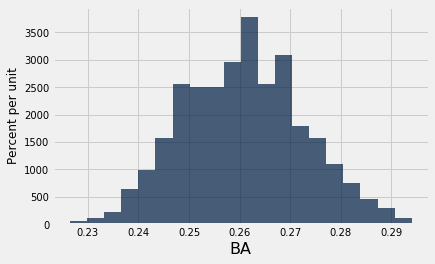

In [6]:
lahman.hist('BA', bins=20)

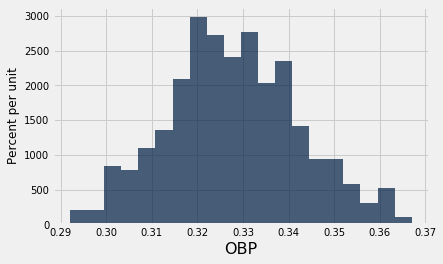

In [7]:
lahman.hist('OBP', bins=20)

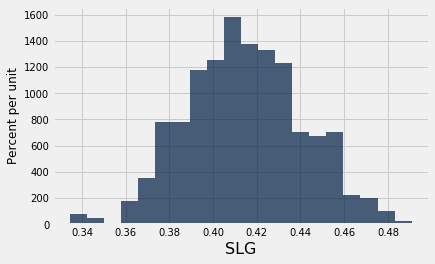

In [8]:
lahman.hist('SLG', bins=20)

### Classical Stats and Runs Scored

We can look at simple scatter plots between the classic stats and runs scored to see how they relate.  We will also compute some metrics that quantify the relationship but suffice to say, having higher values for these metrics will tend to increase run scoring.  The most tenuous relationship definitely appears to be batting average.


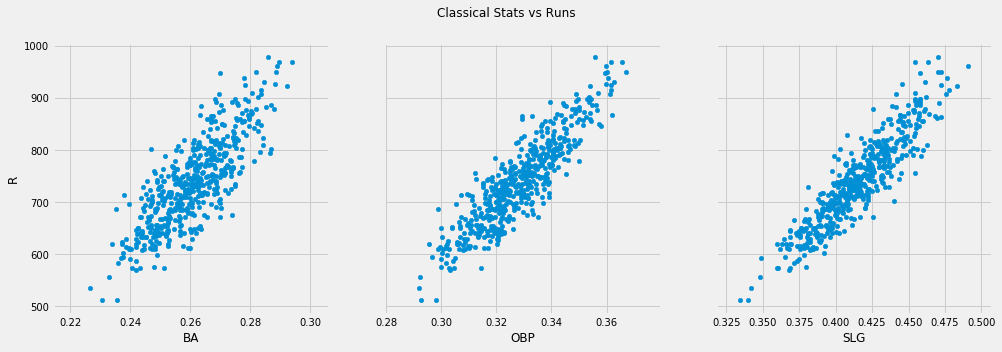

In [9]:
stats = ['BA', 'OBP', 'SLG']
scatterplot_by_x(lahman, stats, 'R', title='Classical Stats vs Runs')

#### Correlation with Team Runs

This is the most involved step of Part I of the lab.  For each of the three classical stats, we need to do four things:
1. Compute a linear relationship between Team Runs and the statistic.  For example, for Batting Average:
$$
    \text{Predicted Team Runs} = \alpha + \beta \cdot \text{Team Batting Average}
$$
Each statistic will have its own $\alpha, \beta$ value.  We are not so interested in those values but rather the predicted value of Team Runs given a Team Batting Average and its error.
2. The error of the prediction in 1:
$$
    \text{Error} = \text{Team Runs} - \text{Predicted Team Runs}
$$
3. The correlation between the statistic and Team Runs
4. Plots of the relationship between Team Runs and the statistic, the linear relationship, and the errors.


##### 1. and 2. Linear Relationship and Error

In [10]:
linear_relationships = {}
errors = {}

linear_fits = Table().with_column('R', lahman['R'])

for i, stat in enumerate(stats):
    # Linear fit
    params, predictions, error = linear_fit(lahman[stat], lahman['R'])
    linear_relationships[stat] = params
    linear_fits = linear_fits.with_column(stat, lahman[stat])
    linear_fits = linear_fits.with_column(stat + '_pred', predictions)
    linear_fits = linear_fits.with_column(stat + '_err', error)

linear_fits.show(10)

R,BA,BA_pred,BA_err,OBP,OBP_pred,OBP_err,SLG,SLG_pred,SLG_err
864,0.279673,845.429,18.5709,0.352355,864.75,-0.749582,0.472459,905.333,-41.3332
792,0.265243,763.743,28.2572,0.333387,766.417,25.5825,0.429347,781.307,10.6932
810,0.271452,798.89,11.1102,0.346477,834.276,-24.276,0.428676,779.376,30.6245
794,0.271761,800.637,-6.63723,0.34058,803.704,-9.70364,0.435033,797.666,-3.66581
792,0.266963,773.476,18.524,0.340547,803.532,-11.5316,0.423446,764.331,27.6694
978,0.286043,881.49,96.5096,0.355692,882.047,95.9529,0.470067,898.452,79.5477
764,0.255693,709.679,54.3214,0.334813,773.808,-9.8082,0.411153,728.966,35.0338
825,0.274179,814.329,10.6714,0.343255,817.574,7.42627,0.447028,832.171,-7.1709
950,0.288404,894.855,55.1452,0.367022,940.783,9.21682,0.470174,898.76,51.2402
968,0.293993,926.494,41.5064,0.361712,913.256,54.7441,0.454594,853.937,114.063


##### 3. Correlation

In [11]:
correlations = {}

for i, stat in enumerate(stats):
    # Correlation
    correlations[stat] = correlation(lahman[stat], lahman['R'])

##### 4. Plotting the results

We put together the results into a simple set of pairs of plots
+ In the first plot we show a scatter plot and the linear relationship between a statistic and team runs.  What is immediately clear is that these stats are in fact related to scoring and not complete nonsense. In fact, if they were all you had, they would be okay.  But as we will see, you can do better.
+ In the second plot, we show the errors between the actual team run values and the predicted values from the linear relationship.  We do this because we want to visually see that OBP and SLG do in fact improve on BA in terms of the size of the errors.  By tending to have smaller error, this shows OBP and SLG correlate/associate with run scoring in a stronger manner than just batting average.

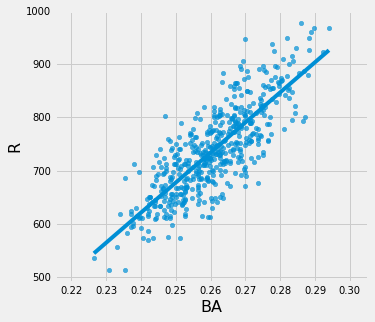

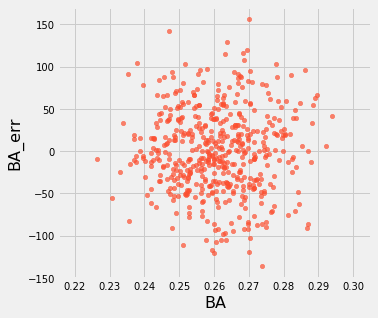

In [12]:
stat = 'BA'
linear_fits.scatter(stat, select='R', fit_line=True, color='C0')
linear_fits.scatter(stat, select=stat + '_err', color='C1')

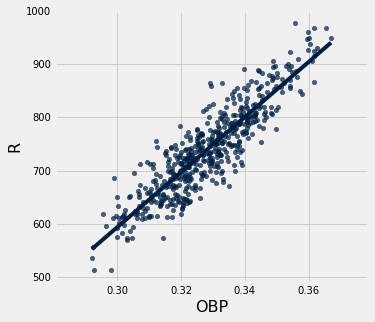

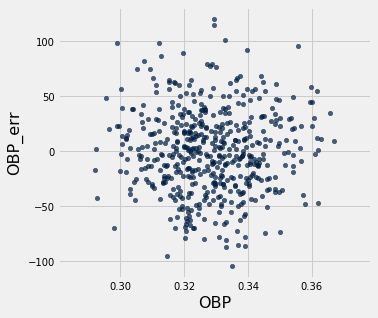

In [13]:
stat = 'OBP'
linear_fits.scatter(stat, select='R', fit_line=True)
linear_fits.scatter(stat, select=stat + '_err')

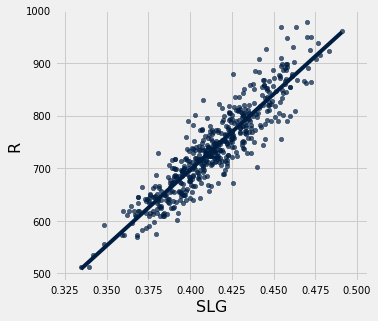

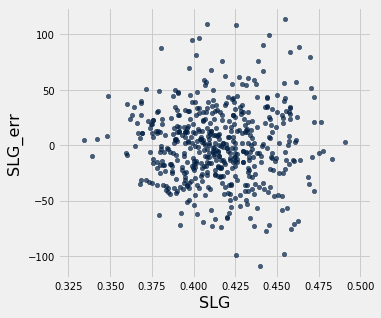

In [14]:
stat = 'SLG'
linear_fits.scatter(stat, select='R', fit_line=True)
linear_fits.scatter(stat, select=stat + '_err')

We also print out some results for each statistic.

In [15]:
def summary_print(stat, corr, err_std):
    print(f"Stat: {stat}")
    print("=" * 20)
    print(f"Correlation with Runs: {corr:.3f}")
    print(f"Std dev of errors (in Runs): {err_std:.3f}")
    print()
    
for stat in stats:
    corr = correlations[stat]
    err_std = np.std(linear_fits[stat + '_err'])
    # Print summary
    summary_print(stat, corr, err_std)

Stat: BA
Correlation with Runs: 0.809
Std dev of errors (in Runs): 49.112

Stat: OBP
Correlation with Runs: 0.892
Std dev of errors (in Runs): 37.683

Stat: SLG
Correlation with Runs: 0.913
Std dev of errors (in Runs): 34.107



The correlation shows that OBP and SLG have a stronger link to run scoring.  The standard deviation of the prediction errors, which measures the overall magnitude of the errors (and is in the units of runs) and shows that errors are dramatically reduced by considering OBP and SLG.  A difference in standard deviation between BA and SLG of 15 runs translates to about 1.5 wins, no small matter.

_Questions_

+ If we came up with a metric that can perfectly predict team run scoring in the period we have been exploring (post year 2000), why should we be suspicious of this metric?
+ What do you think of the implicit assumption that if a metric works well in measuring team performance that it works well at the player level?  Do you have a problem with the assumpion and if so, why?  If not, give a justification for the assumption.

### Correlation Between Statistics

One thing we might wonder is since OBP and SLG are seemingly both improvements on BA, are they telling us something different?  Well, for one, based on the construction we know that has to be true.  The extra weighting of extra base hits means they cannot possibly be the same.  But to what extent are they different?  

Well, we can look at the correlations between the three statistics to see how closely they relate to each other.  We find that OBP is pretty closely linked to BA and we know that whatever difference exists there is due entirely to ignoring walks and hit py pitch events. 

SLG shows a lower correlation with either BA and OBP, clearly due to its weighting for extra base hits.

In [16]:
rho_obp_ba = correlation(lahman["OBP"], lahman['BA'])
rho_obp_slg = correlation(lahman["OBP"], lahman['SLG'])
rho_ba_slg = correlation(lahman["BA"], lahman['SLG'])

print(f" BA and OBP: {rho_obp_ba:.3f}")
print(f" BA and SLG: {rho_ba_slg:.3f}")
print(f"OBP and SLG: {rho_obp_slg:.3f}")

 BA and OBP: 0.844
 BA and SLG: 0.758
OBP and SLG: 0.781


_Question_
+ Why does it matter that OBP and SLG correlate with team runs but not completely with each other?

## Advanced Statistics

### OPS

OPS stands for "On-Base Plus Slugging".  It is a well-known metric and is often the first foray into "advanced" stats for people.

### wOBA

wOBA stands for "Weighted On Base Average"

#### Computing Team wOBA and OPS

OPS is easy to compute as its title suggests.  Using the dataset from the Lahman database, we can use the wOBA weights to compute team wOBA.

In [ ]:
# Team OPS
lahman['OPS'] = lahman['OBP'] + lahman['SLG']

In [ ]:
# Team wOBA
woba_numerator = wOBA_weights['1B'] * lahman['1B']
for event in ['2B', '3B', 'HR', 'BB', 'HBP']:
    woba_numerator += wOBA_weights[event] * lahman[event]
    
lahman['wOBA']= woba_numerator / lahman['PA']

#### Linear fits and correlations for OPS and wOBA

To do:
1. Use the previous correlation and linear fit analysis for BA, OBP, and SLG and compute the corresponding quantities for OPS and wOBA.
2. Generate the same scatter plots of OPS and wOBA vs Runs Scored as well as the scatter plots on the errors.
3. Use the `stat_summary_print` function to print out the results
4. Generate the correlation between wOBA and OPS

_Questions_
1. What does the value of OPS mean to you?  Aside from placing someone's OPS value in relation to other players, does a value of 1.000 mean anything?  Does it have units?
2. Since Batting Runs or wRAA is in terms of runs, how does it contrast with OPS?  (This applies less to wOBA since the fact that we are using the wOBA scaling distorts the meaning of wOBA)
3. If a metric works, why might you prefer not to use it compared to something else?

Correlation with Team Runs

We return to the analysis done in Part I regarding offensive metrics and how the correlate with team run scoring.

In addition to wOBA, we also compute well-known metric OPS, which stands for "On-Base Plus Slugging".

We also need to mention a huge caveat with regards to wOBA: we are using 2001 wOBA weights for all seasons we are using from the Lahman database.  We should not be doing this.  We should be using weights we've computed for each year.  The weights do not change too much and you will see some definitions of wOBA used fixed value of weights and changing wOBA_scale values.  For the purposes of this analysis, this should be not be much of an issue as it gets the spirit across and is close enough.

In Part I, we observed that both OBP and SLG were reasonably well correlated with team run scoring but also did not fully overlap.  OPS aims to exploit this by combining the two metrics.  That way we can try to get the best of both worlds in terms of measuring on-base skill and measuring power.

We end up finding that OPS and wOBA both do quite well in providing a better association with run scoring.  The correlations are higher and the standard deviation of the errors is much improved.  That said, while both are very similar when we evaluate their performance, there is one reason to prefer wOBA and metrics that are similarly built out of the notion of run expectancy and the linear weights values: they are actually computed in the proper units of runs.  OPS is more or less just a meaningless value that is the sum of two metrics that shouldn't be summed.  

# Wrapping up

Okay, this was a pretty fun entry into developing some empirically driven approaches to measuring performance.

Some final questions:

+ What does our analysis say about future performance?  Does it say anything? 
+ Say a player has a .400 wOBA for a season.  What might we want to know about the metric wOBA when evaluating the player and valuing the player's future performance?